#  PART 1 - Web Scraping

# **Import Libraries**

In [20]:
# import all libraries selenium related

from __future__ import print_function
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import (NoSuchElementException , ElementClickInterceptedException, TimeoutException)

In [21]:
# import all libraries for link extraction 

import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
import lxml
import requests

In [22]:
from settings import search_keys
import json
import time
import re
import datetime
import argparse
import matplotlib as plt

In [23]:
from __future__ import print_function
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

#  **Glassdoor** 

Glassdoor is a website where current and former employees anonymously review companies. Glassdoor also allows users to anonymously submit and view salaries as well as search and apply for jobs on its platform.

(from wikipedia)


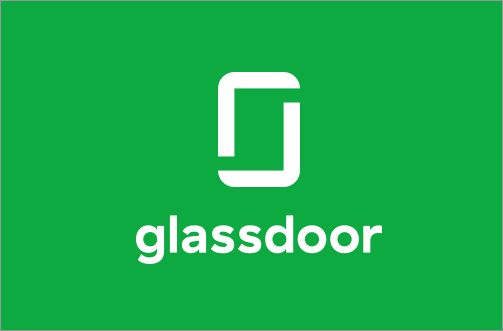

In [24]:
# Specifyinng number of jobs as an excessive number of requests made by the computer IP can potentially block you
# glassdoor has 30 listing per page, so we calculated manually how much is the total amount of jobs present 
# i.e (num_pages*30)

num_jobs = 150
start_pg =1 
end_pg = 30
total_pages = 30

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage') 
driver = webdriver.Chrome('chromedriver' , options = options)

In [25]:
def scrape_links(driver , start_pg , end_pg ,total_pages):
    
    ''' 
    
    This function uses selenium and beautiful soup(BS4) to extract the page source.
    
    '''
     
    url_head = 'https://www.glassdoor.com.br'
    scr_links = [] 
    
    # Total pages are the total web pages on the website.
    if end_pg > total_pages:
        print("Enter valid Page Indexes")
    #br = self.Initialize_Driver()
    br = driver
    for pg_num in range(start_pg, end_pg+1):
        url = 'https://www.glassdoor.com.br/Vaga/s%C3%A3o-paulo-data-scientist-vagas-SRCH_IL.0,9_IC2479061_KO10,24'+'.htm?radius=124'
        br.get(url)
        br.implicitly_wait(5)
        
        soup = BeautifulSoup(br.page_source , 'lxml')
        #print(f"Scraping Page Number : {pg_num}")      
        for a_tag in soup.find_all('a', {'class':'jobInfoItem jobTitle jobLink'}):
            scr_links.append(a_tag['href'])
            
            
    op_links = list(set(scr_links))
    if len(op_links) == ((end_pg-start_pg)+1)*30:
        print("Scraping of links is completed")
        
        return op_links
    
    
    
def scrape_data(num_jobs, driver, links):
    
    #data_df = df
    #cleaned_links = scrape_links(br)
    #if data_df is None:
    data_df = pd.DataFrame(columns = ['Job_title' , 'Company' , 'State' , 'City', 'Job_Desc' , 
                                           'Industry' , 'Date_Posted' , 'Valid_until' , 'Job_Type' ,
                                      ])
    br = driver
    start = time.time()
    print("Gathering Information")
    
    br = driver
    for job in range(num_jobs):
        br.get(links[job])
        br.implicitly_wait(10)
        soup = BeautifulSoup(br.page_source , 'lxml')

        try:
            # the rest of the data is available in scrip = 'application/ld+json' i.e in  json file
            json_file = soup.find('script' , {'type':'application/ld+json'})
            op_json = json.loads(str(json_file.decode_contents()) , strict = False)
                
            #title
            try:
                title = op_json['title']
                print(title)
            except:
                title  = None
                
            # dateposted
            try:
                post_date = op_json['datePosted']
            except:
                post_date = None
                
            #type
            try:
                job_type = op_json['employmentType']
            except:
                job_type = None

                
            #Job Posting validity date(Y-M-D)
            try:
                valid_date = op_json['validThrough']
            except:
                valid_date = None
                
            #Industry
            try:
                industry = op_json['industry']
            except:
                industry = None
                
            #Location
            try:
                city = op_json['jobLocation']['address']['addressLocality']
                state = op_json['jobLocation']['address']['addressRegion']
            except:
                city , state = None , None

            #Company
            try:
                company = op_json['hiringOrganization']['name']
            except:
                company = None
                
            #Let's get Description
            try:
                desc = soup.find(class_ = 'desc').text
            except:
                desc = None
            try:
                rating = soup.find('span' , {'class' : 'css-nimzbu e1eh6fgm0'}).text.replace('*' , '')
                
            except:
                rating = None


            
            data_df = data_df.append({'Job_title' : title,
                                      'Company' : company,
                                      'State' : state,
                                      'City' : city,
                                      'Job_Desc' : desc,
                                      'Industry':industry,
                                      'Date_Posted' : post_date,
                                      'Valid_until' : valid_date,
                                      'Job_Type' :job_type
                                       } , ignore_index = True)
        except:
            pass
        
    driver.close()
    print(f"Scraping Completed for {data_df.shape[0]} jobs")
    print(f"Time Required : {time.time() - start} seconds")
        
    return data_df

In [33]:
total_jobs = 30*(end_pg - start_pg+1)
f_df = pd.DataFrame(columns = ['Job_title', 'Company','State' ,'City', 'Job_Desc' , 
                                'Industry', 'Date_Posted', 'Valid_until', 'Job_Type'])
br = driver
links = scrape_links(br, start_pg, end_pg, total_pages)
dummy_df = scrape_data(10 , br, links)

# exctract 150 jobs every 1 mins 

for i in range(total_jobs//num_jobs):
    df = scrape_data(num_jobs , br , links[num_jobs*i : num_jobs*(i+1)])
    f_df = f_df.append(df)
    time.sleep(30)

InvalidSessionIdException: Message: invalid session id


In [31]:
# save the file to csv

f_df.to_csv('glassdoor_jobs.csv' , index = False)

In [29]:
pd.read_csv('glassdor_jobs.csv')

FileNotFoundError: [Errno 2] File glassdor_jobs.csv does not exist: 'glassdor_jobs.csv'

# **Linkedin**

LinkedIn is an American business and employment-oriented online service that operates via websites and mobile apps. Launched on May 5, 2003, it is mainly used for professional networking, including employers posting jobs and job seekers posting their CVs.

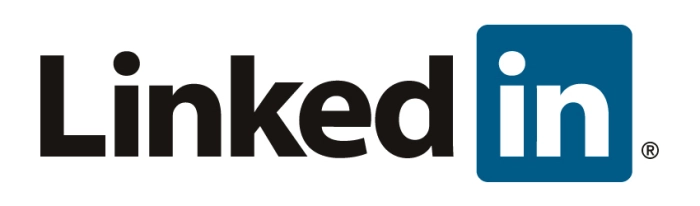

In [ ]:
def job_id(driver):
    
    """
    
    grabs the meta linkedin unique job id from the url
    e.g. url = https://www.linkedin.com/jobs/view/161251904
    returns 161251904
    
    """
    elem = driver.find_element_by_xpath("//meta[@property='og:url']")
    url  = elem.get_attribute("content")
    return url[url.find('/', 34) + 1:]

def parse_post_age(text):
    
        """ 
        
        map 'posted 10 days ago' => '10' 
        
        """
        if 'hours' in text:
            return '1'
        return ''.join(list(filter(lambda c: c.isdigit(), text)))

def post_data(driver):
    
    """
    
    get post age and page views and trim excess words
    so that 'posted 10 days ago' becomes '10'
    and '63 views' becomes '63' 
    
    """
    post_info = {
        "post_age"   : "li.posted", 
        "page_views" : "ul.posting-info li.views"
    }
    for key, selector in post_info.items():
        try:
            text = driver.find_element_by_css_selector(selector).text
            if key == "post_age":
                post_info[key] = parse_post_age(text)
            else:
                post_info[key] = ''.join(list(filter(lambda c: c.isdigit(), text)))
        except Exception as e:
            post_info[key] = ""
            pass
    return post_info

def job_data(driver):
    
    """
    
    scrapes the posting info for title, company, post age, location,
    and page views. Have seen many strange errors surrounding the
    job tite, company, location data, so have used many try-except
    statements to avoid potential errors with unicode, etc.
    
    """
    
    job_info = {
        "job_title"        :  "h1.title",
        "company"          :  "span.company",
        "location"         :  "h3.location",
        "employment_type"  :  "div.employment div.content div.rich-text",
        "industry"         :  "div.industry div.content div.rich-text",
        "experience"       :  "div.experience div.content div.rich-text",
        "job_function"     :  "div.function div.content div.rich-text",
        "description"      :  "div.summary div.content div.description-section div.rich-text"
    }
    
    try:
        driver.find_element_by_css_selector("button#job-details-reveal").click()
    except Exception as e:
        print("error in attempting to click 'reveal details' button")
        print(e)
    for key, selector in job_info.items():
        try:
            job_info[key] = driver.find_element_by_css_selector(selector).text
        except Exception as e:
            job_info[key] = ""
            pass
    return job_info

def company_data(driver):
    
    """
    
    return company insights, number of employees and average tenure
    
    """
    
    try:
        stats_selector = "ul.company-growth-stats.stats-list li"
        company_stats  = driver.find_elements_by_css_selector(stats_selector)
        company_info   = [stat.text for stat in company_stats]
    except Exception as e:
        print("error acquiring company info")
        print(e)
    else:
        try:
            employees     = list(filter(lambda text: 'employees' in text, company_info))
            num_employees = ''.join(list(filter(lambda c: c.isdigit(), employees[0])))
        except Exception as e:
            num_employees = ""
            pass
        try:
            tenure        = list(filter(lambda text: 'tenure' in text, company_info))
            avg_tenure    = ''.join(list(filter(lambda c: c in '0123456789.', tenure[0])))
        except Exception as e:
            avg_tenure    = ""
            pass
        company_info  = {
            "avg_tenure"    : avg_tenure, 
            "num_employees" : num_employees
        }
    return {"avg_tenure" : avg_tenure, "num_employees" : num_employees}


def salary_data(driver):
    
    """
    
    scrapes the salary info chart on the right panel returns lower, 
    upper bounds on salary estimate as well as average salary
    
    """
    
    try:
        _base = driver.find_element_by_xpath('/descendant::p[@class="salary-data-amount"][1]').text
        _total = driver.find_element_by_xpath('/descendant::p[@class="salary-data-amount"][2]').text
        _base_range = driver.find_element_by_xpath('/descendant::p[@class="salary-data-range"][1]').text
        _total_range = driver.find_element_by_xpath('/descendant::p[@class="salary-data-range"][2]').text
        return {
            "base" : ''.join(list(filter(lambda c: c.isdigit(), _base))),
            "total" : ''.join(list(filter(lambda c: c.isdigit(), _total))),
            "base_range": _base_range,
            "total_range": _total_range
        }
    except Exception as e:
        print("error acquiring salary info")
        print(e)
        pass
    return {"base": "", "total": "", "base_range": "", "total_range": ""}

def num_applicants(driver):
    
    """
    
    Grabs number of applicants from either the header of the 
    applicants-insights div, or within the applicants-table in the same 
    div element. Returns empty string if data is not available.
    
    """
    
    # use two selectors since LI has two methods of showing number
    # of applicants in the applicants-insights driver
    num_applicant_selectors = [
        "span.applicant-rank-header-text",
        "table.other-applicants-table.comparison-table tr td",
        "p.number-of-applicants"
    ]
    for selector in num_applicant_selectors:
        try:
            num_applicants = driver.find_element_by_css_selector(selector).text
        except Exception as e:
            pass
        else:
            return ''.join(list(filter(lambda c: c.isdigit(), num_applicants)))
    return ''

def applicants_education(driver):
    
    """
    
    return dictionary of applicant education levels
    
    """
    
    education_selector = "table.applicants-education-table.comparison-table tbody tr"
    
    try:
        education = driver.find_elements_by_css_selector(education_selector)
        if education:
            # grab the degree type and proportion of applicants with that
            # degree.
            remove = ["have", "a", "Degree", "degrees", "(Similar", "to", "you)"]
            edu_map = list(map(
                    lambda edu: list(filter(
                            lambda word: word not in remove, 
                            edu
                        )), 
                    [item.text.split() for item in education]
                ))
            # store the education levels in a dictionary and prepare to 
            # write it to file
            edu_dict = {
                "education" + str(i + 1) : { 
                                    "degree" : ' '.join(edu_map[i][1:]), 
                                    "proportion": edu_map[i][0]
                                } 
                for i in range(len(edu_map))
            }
            return edu_dict
    except Exception as e:
        print("error acquiring applicants education")
        print(e)
    return {}

def applicants_locations(driver):
    
    """
    
    scrapes the applicants-insights-hover-content div on a 
    given job page. Grabs the location and number of applicants 
    from each location.
    
    """
    
    applicants_info = {}
    try:
        elem = driver.find_elements_by_css_selector("a.location-title")
        for i in range(len(elem)):
            # city and applicants are separated by a new line
            city, applicants = elem[i].text.split('\n')
            # get number of applicants by removing the word 'applicants'
            applicants = applicants[:applicants.find(" applicants")]
            # enter, typically, three applicant location data pairs
            location_data  = {
                "city"       : city, 
                "applicants" : applicants
            }
            applicants_info["location" + str(i + 1)] = location_data
    except Exception as e:
        print("error acquiring applicants locations")
        print(e)
    return applicants_info

def applicants_skills(driver):
    
    """
    
    scrapes applicant skills by finding 'pill' tags in html
    returns list of skills. If skills not present on page, then
    returns empty list
    
    """
    
    try:
        raw_skills = driver.find_elements_by_css_selector("span.pill")
        skills     = [skill.text for skill in raw_skills] 
        return skills
    except Exception as e:
        print("error acquiring applicant skills")
        print(e)
    return []

def scrape_page(driver, **kwargs):
    
    """
    
    scrapes single job page after the driver loads a new job posting.
    Returns data as a dictionary
    
    """
    # wait ~1 second for elements to be dynamically rendered
    time.sleep(1.2)
    start = time.time()
    containers = [
        "section#top-card div.content",            # job content
        "div.job-salary-container",                # job salary
        "ul.company-growth-stats.stats-list",      # company stats
        "div.insights-card.applicants-skills",     # applicants skills
        "div.applicants-locations-list"            # applicants locations
    ]
    for container in containers:
        try:
            WebDriverWait(driver, .25).until(
                EC.presence_of_element_located(
                    (By.CSS_SELECTOR, container)
                    )
                )
        except Exception as e:
            print("timeout error waiting for container to load or element" \
                  " not found: {}".format(container))
            print(e)
    applicant_info = {
        "num_applicants"    :  num_applicants(driver),
        "skills"            :  applicants_skills(driver),
        "education"         :  applicants_education(driver),
        "locations"         :  applicants_locations(driver)
    }
    job_info = {
        "job_id"            :  job_id(driver),
        "salary_estimates"  :  salary_data(driver),
        "company_info"      :  company_data(driver)
    }
    
    job_info.update(job_data(driver))
    
    data = {
        "applicant_info"    :  applicant_info,
        "job_info"          :  job_info,
        "post_info"         :  post_data(driver),
        "search_info"       :  kwargs
    }
    print("scraped page in  {}  seconds\n".format(time.time()-start))
    
    # try:
    #     print("data:\n\n{}\n".format(data))
    # except Exception as e:
    #     print("data could not be printed to console\n")
    return data

In [ ]:
def write_line_to_file(filename, data):
    
    """
    
    output the current job title, company, job id, then write
    the scraped data to file
    
    """
    job_title = data["job_info"]["job_title"]
    company   = data["job_info"]["company"]
    job_id    = data["job_info"]["job_id"]
    message = u"Writing data to file for job listing:"
    message += "\n  {}  {};   job id  {}\n"
    try:
        print(message.format(job_title, company, job_id))
    except Exception as e:
        print("Encountered a unicode encode error while attempting to print " \
              "the job post information;  job id {}".format(job_id))
    with open(filename, "a") as f:
        f.write(json.dumps(data) + '\n')

def get_date_time():
    
    """
    
    get the full date along with the hour of the search, just for 
    completeness. Allows us to solve for of the original post 
    date.
    
    """
    
    now   =  datetime.datetime.now()
    month =  str(now.month) if now.month > 6 else '0' + str(now.month)
    day   =  str(now.day) if now.day > 6 else '0' + str(now.day)
    date  =  ''.join(str(t) for t in [now.year, month, day, now.time().hour])
    return date

def adjust_date_range(driver, date_range):
    
    """
    
    select a specific date range for job postings
    
    """
    
    if date_range == 'All':
        return
    index = ['', 'All', '1', '2-7', '8-14', '15-30'].index(date_range)
    button_path = "html/body/div[3]/div/div[2]/div[1]/div[4]/form/div/ul/li" \
                  "[3]/fieldset/button"
    date_path = "html/body/div[3]/div/div[2]/div[1]/div[4]/form/div/ul/li" \
                "[3]/fieldset/div/ol/li[{}]/div/label".format(index)
    attempts = 1
    
    while True:
        try:
            elem = driver.find_element_by_xpath(button_path)
            time.sleep(3)
        except Exception as e:
            attempts += 1
            if attempts > 25:
                break
        else:
            elem.click()
            time.sleep(3)
            driver.find_element_by_xpath(date_path).click()
            time.sleep(3)
            break 

def adjust_search_radius(driver, search_radius):
    
    """
    
    select the appropriate user-defined search radius from the 
    dropdown window
    
    """
    if search_radius == '50':
        return
    distance_selector = "select#advs-distance > option[value='{}']"
    distance_selector = distance_selector.format(search_radius)
    
    try:
        driver.find_element_by_css_selector(distance_selector).click()
        
    except Exception as e:
        print(e)
        
    else:
        time.sleep(3)
        
        try:
            driver.find_element_by_css_selector("input.submit-advs").click()
            time.sleep(3)
            
        except Exception as e:
            print(e)

def adjust_salary_range(driver, salary):
    
    """
    
    adjust the salary range, default is All salaries
    
    """
    
    if salary == 'All': 
        return
    index = ['', 'All', '40+', '60+', '80+', '100+', 
                        '120+', '160+', '180+', '200+'].index(salary)
    salary_button = "html/body/div[3]/div/div[2]/div[1]/div[4]/form/div/ul/" \
                                    "li[4]/fieldset/button"
    salary_path = "html/body/div[3]/div/div[2]/div[1]/div[4]/" \
                  "form/div/ul/li[4]/fieldset/div[1]/ol/li[{}" \
                  "]/div/label".format(index)
    attempts = 1
    
    while True:
        try:
            elem = driver.find_element_by_xpath(salary_button)
            time.sleep(3)
            
        except Exception as e:
            attempts += 1
            if attempts > 25: 
                break
        else:
            elem.click()
            time.sleep(3)
            driver.find_element_by_xpath(salary_path).click()
            break

def sort_results_by(driver, sorting_criteria):
    
    """
    sort results by either relevance or date posted
    
    """
    
    if sorting_criteria.lower() == 'relevance':
        
        return
    button = '//select[@id="jserp-sort-select"]'
    option_path = '//option[@value="DD"]'
    time.sleep(3)
    
    try:
        driver.find_element_by_xpath(button).click()
        
    except Exception as e:
        print(e)
        print(" Could not sort results by '{}'".format(sorting_criteria))
        
    else:
        time.sleep(3)
        
        try:
            driver.find_element_by_xpath(option_path).click()
            
        except Exception as e:
            print("  Could not select 'sort by' option")
            
        else:
            time.sleep(3)

def robust_wait_for_clickable_element(driver, delay, selector):
    
    """
    wait for css selector to load 
    
    """
    
    clickable = False
    attempts = 1
    try:
        driver.find_element_by_xpath(selector)
        
    except Exception as e:
        print("Selector not found: {}".format(selector))
        
    else:
        
        while not clickable:
            
            try:
                # wait for job post link to load
                wait_for_clickable_element(driver, delay, selector)
                
            except Exception as e:
                print("  {}".format(e))
                attempts += 1
                if attempts % 100 == 0:
                    driver.refresh()
                if attempts > 10**3: 
                    print("  \nrobust_wait_for_clickable_element failed " \
                                    "after too many attempts\n")
                    break
                pass
            
            else:
                clickable = True

def robust_click(driver, delay, selector):
    """
    
    use a while-looop to click an element. For stubborn links
    and general unexpected browser errors.
    
    """
    
    try:
        driver.find_element_by_xpath(selector).click()
        
    except Exception as e:
        print("  The job post link was likely hidden,\n    An " \
                "error was encountered while attempting to click link" \
                "\n    {}".format(e))
        attempts = 1
        clicked = False
        
        while not clicked:
            try:
                driver.find_element_by_xpath(selector).click()
                
            except Exception as e:
                pass
            
            else:
                clicked = True
                print("  Successfully navigated to job post page "\
                            "after {} attempts".format(attempts))
            finally:
                attempts += 1
                
                if attempts % 100 == 0:
                    print("--------------  refreshing page")
                    driver.refresh()
                    time.sleep(5)
                if attempts > 10**3:
                    print(selector)
                    print("  robust_click method failed after too many attempts")
                    break 


def wait_for_clickable_element(driver, delay, selector):
    
    """
    
    use WebDriverWait to wait for an element to become clickable
    
    """
    
    obj = WebDriverWait(driver, delay).until(
            EC.element_to_be_clickable(
                (By.XPATH, selector)
            )
        )
    return obj  

def wait_for_clickable_element_css(driver, delay, selector):
    
    """
    
    use WebDriverWait to wait for an element to become clickable
    
    """
    
    obj = WebDriverWait(driver, delay).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, selector)
            )
        )
    return obj  


def link_is_present(driver, delay, selector, index, results_page):
    
    """
    
    verify that the link selector is present and print the search 
    details to console. This method is particularly useful for catching
    the last link on the last page of search results
    
    """
    
    try:
        WebDriverWait(driver, delay).until(
            EC.presence_of_element_located(
                (By.XPATH, selector)
            )
        )
        print("**************************************************")
        print("\nScraping data for result  {}" \
                "  on results page  {} \n".format(index, results_page))
        
    except Exception as e:
        print(e)
        if index < 25:
            print("\nWas not able to wait for job_selector to load. Search " \
                    "results may have been exhausted.")
            return True
        
        else:
            return False
        
    else:
        return True 


def search_suggestion_box_is_present(driver, selector, index, results_page):
    """
    
    check results page for the search suggestion box,
    as this causes some errors in navigate search results.
    
    """
    if (index == 1) and (results_page == 1):
        try:
            # This try-except statement allows us to avoid the 
            # problems cause by the LinkedIn search suggestion box
            driver.find_element_by_css_selector("div.suggested-search.bd")
        except Exception as e:
            pass
        else:
            return True
    else:
        return False
    

def next_results_page(driver, delay):
    
    """
    
    navigate to the next page of search results. If an error is encountered
    then the process ends or new search criteria are entered as the current 
    search results may have been exhausted.
    
    """
    
    try:
        # wait for the next page button to load
        print("  Moving to the next page of search results... \n" \
                "  If search results are exhausted, will wait {} seconds " \
                "then either execute new search or quit".format(delay))
        wait_for_clickable_element_css(driver, delay, "a.next-btn")
        # navigate to next page
        driver.find_element_by_css_selector("a.next-btn").click()
        
    except Exception as e:
        print ("\nFailed to click next page link; Search results " \
                                "may have been exhausted\n{}".format(e))
        raise ValueError("Next page link not detected; search results exhausted")
        
    else:
        # wait until the first job post button has loaded
        first_job_button = "a.job-title-link"
        # wait for the first job post button to load
        wait_for_clickable_element_css(driver, delay, first_job_button)

def go_to_specific_results_page(driver, delay, results_page):
    
    """
    
    go to a specific results page in case of an error, can restart 
    the webdriver where the error occurred.
    
    """
    if results_page < 2:
        return
    current_page = 1
    for i in range(results_page):
        current_page += 1
        time.sleep(5)
        try:
            next_results_page(driver, delay)
            print("\n**************************************************")
            print("\n\n\nNavigating to results page {}" \
                  "\n\n\n".format(current_page))
        except ValueError:
            print("**************************************************")
            print("\n\n\n\n\nSearch results exhausted\n\n\n\n\n")

def print_num_search_results(driver, keyword, location):
    
    """
    
    print the number of search results to console
    
    """
    # scroll to top of page so first result is in view
    driver.execute_script("window.scrollTo(0, 0);")
    selector = "div.results-context div strong"
    try:
        num_results = driver.find_element_by_css_selector(selector).text
    except Exception as e:
        num_results = ''
    print("**************************************************")
    print("\n\n\n\n\nSearching  {}  results for  '{}'  jobs in  '{}' " \
            "\n\n\n\n\n".format(num_results, keyword, location))

def extract_transform_load(driver, delay, selector, date, 
                           keyword, location, filename):
    """
    
    using the next job posting selector on a given results page, wait for
    the link to become clickable, then navigate to it. Wait for the job 
    posting page to load, then scrape the page and write the data to file.
    Finally, go back to the search results page
    
    """
    
    # wait for the job post to load then navigate to it
    try:
        wait_for_clickable_element(driver, delay, selector)
        robust_click(driver, delay, selector)
        
    except Exception as e:
        print("error navigating to job post page")
        print(e)
        
    try:
        # wait for the premium applicant insights to load
        # wait_for_clickable_element(driver, delay, "div.premium-insights")
        WebDriverWait(driver, delay).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "div.premium-insights")
                )
            )
    except Exception as e:
        print(e)

    try:
        # scrape page and prepare to write the data to file
        data = scrape_page(driver, keyword=keyword, location=location, dt=date)
    except Exception as e:
        print("\nSearch results may have been exhausted. An error was " \
                "encountered while attempting to scrape page data")
        print(e)
    else:
        # write data to file
        write_line_to_file(filename, data)
    finally:
        if not ("Search | LinkedIn" in driver.title):
            driver.execute_script("window.history.go(-1)")


class LIClient(object):
    
    def __init__(self, driver, **kwargs):
        self.driver         =  driver
        self.username       =  kwargs["username"]
        self.password       =  kwargs["password"]
        self.filename       =  kwargs["filename"]
        self.date_range     =  kwargs["date_range"]
        self.search_radius  =  kwargs["search_radius"]
        self.sort_by        =  kwargs["sort_by"]
        self.salary_range   =  kwargs["salary_range"]
        self.results_page   =  kwargs["results_page"]

    def driver_quit(self):
        self.driver.quit()

    def login(self):
        
        """
        login to linkedin then wait 3 seconds for page to load
        """
        # Enter login credentials
        WebDriverWait(self.driver, 120)
      
        elem = self.driver.find_element_by_id("username")
        elem.send_keys(self.username)
        elem = self.driver.find_element_by_id("password")
        elem.send_keys(self.password)
        # Enter credentials with Keys.RETURN
        elem.send_keys(Keys.RETURN)
        # Wait a few seconds for the page to load
        time.sleep(3)

    def navigate_to_jobs_page(self):
        
        """
        
        navigate to the 'Jobs' page since it is a convenient page to 
        enter a custom job search.
        
        """
        
        # Click the Jobs search page
        jobs_link_clickable = False
        attempts = 1
        url = "https://www.linkedin.com/jobs/?trk=nav_responsive_sub_nav_jobs"
        while not jobs_link_clickable:
            try:
                self.driver.get(url)
            except Exception as e:
                attempts += 1
                if attempts > 10**3: 
                    print("  jobs page not detected")
                    break
                pass
            else:
                print("**************************************************")
                print ("\n\n\nSuccessfully navigated to jobs search page\n\n\n")
                jobs_link_clickable = True

    def enter_search_keys(self):
        
        """
        execute the job search by entering job and location information.
        The location is pre-filled with text, so we must clear it before
        entering our search.
        
        """
        driver = self.driver
        WebDriverWait(driver, 120)
        
        # Enter search criteria
        elem = driver.find_element_by_id("jobs-search-box-location-id-ember544")
        elem.send_keys(self.keyword)
        # clear the text in the location box then enter location
        elem = driver.find_element_by_id("jobs-search-box__text-input").clear()
        elem = driver.find_element_by_id("jobs-search-box__text-input")
        elem.send_keys(self.location)
        elem.send_keys(Keys.RETURN)
        time.sleep(3)

    def customize_search_results(self):
        
        """
        
        sort results by either relevance or date posted
        
        """
        
        adjust_date_range(self.driver, self.date_range)
        adjust_salary_range(self.driver, self.salary_range)
        # adjust_search_radius(self.driver, self.search_radius) # deprecated
        # scroll to top of page so the sorting menu is in view
        self.driver.execute_script("window.scrollTo(0, 0);")
        sort_results_by(self.driver, self.sort_by)

    def navigate_search_results(self):
        
        """
        
        scrape postings for all pages in search results
        
        """
        
        driver = self.driver
        search_results_exhausted = False
        results_page = self.results_page
        delay = 60
        date = get_date_time()
        # css elements to view job pages
        list_element_tag = '/descendant::a[@class="jobs-details-top-card__job-title-link ember-view"]'
        print_num_search_results(driver, self.keyword, self.location)
        # go to a specific results page number if one is specified
        go_to_specific_results_page(driver, delay, results_page)
        results_page = results_page if results_page > 1 else 1

        while not search_results_exhausted:
            for i in range(1,26):  # 25 results per page
                # define the css selector for the blue 'View' button for job i
                job_selector = list_element_tag + str(i) + ']'
                if search_suggestion_box_is_present(driver, 
                                            job_selector, i, results_page):
                    continue
                # wait for the selector for the next job posting to load.
                # if on last results page, then throw exception as job_selector 
                # will not be detected on the page
                if not link_is_present(driver, delay, 
                                         job_selector, i, results_page):
                    continue
                robust_wait_for_clickable_element(driver, delay, job_selector)
                extract_transform_load(driver,
                                       delay,
                                       job_selector,
                                       date,
                                       self.keyword,
                                       self.location,
                                       self.filename)
            # attempt to navigate to the next page of search results
            # if the link is not present, then the search results have been 
            # exhausted
            
            try:
                next_results_page(driver, delay)
                print("\n**************************************************")
                print("\n\n\nNavigating to results page  {}" \
                      "\n\n\n".format(results_page + 1))
            except ValueError:
                search_results_exhausted = True
                print("**************************************************")
                print("\n\n\n\n\nSearch results exhausted\n\n\n\n\n")
            else:
                results_page += 1
                

In [ ]:
def parse_command_line_args():
    """
                                     
    parse LinkedIn search parameters
        
    """
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--username', default=search_keys['username'], nargs='*',
        help="""
        
        enter LI username
        
        """)
        
    parser.add_argument('--password', default=search_keys['password'], nargs='*',
        help="""
        
        enter LI password""")
        
    parser.add_argument('--keywords', default=search_keys['keywords'], nargs='*', 
        help="""
        
        enter search keys separated by a single space. If the keyword is more
        than one word, wrap the keyword in double quotes.
        
        """)
        
    parser.add_argument('--locations', default=search_keys['locations'], nargs='*',
        help="""
        
        enter search locations separated by a single space. If the location 
        search is more than one word, wrap the location in double quotes.
        
        """)
        
    parser.add_argument('--search_radius', type=int, default=search_keys['search_radius'], nargs='?',
        help="""
        
        enter a search radius (in miles). Possible values are: 10, 25, 35, 
        50, 75, 100. Defaults to 50.
        
        """)
        
    parser.add_argument('--results_page', type=int, default=search_keys['page_number'], nargs='?', 
        help="""
        
        enter a specific results page. If an unexpected error occurs, one can
        resume the previous search by entering the results page where they 
        left off. Defaults to first results page.
        
        """)
    
    parser.add_argument('--date_range', type=str, default=search_keys['date_range'], nargs='?', 
        help=
       """
        
        specify a specific date range. Possible values are: All, 1, 2-7, 8-14,
        15-30. Defaults to 'All'.
        
        """)
    
    parser.add_argument('--sort_by', type=str, default=search_keys['sort_by'], nargs='?', 
        help=
        """
        
        sort results by relevance or date posted. If the input string is not 
        equal to 'Relevance' (case insensitive), then results will be sorted 
        by date posted. Defaults to sorting by relevance.
        
        """)
    
    parser.add_argument('--salary_range', type=str, default=search_keys['salary_range'], nargs='?', 
        help="""
        
        set a minimum salary requirement. Possible input values are:
        All, 40+, 60+, 80+, 100+, 120+, 140+, 160+, 180+, 200+. Defaults
        to All.
        
        """)
    
    parser.add_argument('--filename', type=str, default=search_keys['filename'], nargs='?', 
        help="""
        
        specify a filename to which data will be written.
        
        """)
    
    return vars(parser.parse_args())

if __name__ == "__main__":

    search_keys = parse_command_line_args()

    # initialize selenium webdriver - pass latest chromedriver path to webdriver.Chrome()
    driver = webdriver.Chrome('/usr/bin/chromedriver')
    driver.get("https://www.linkedin.com/uas/login")

    # initialize LinkedIn web client
    liclient = LIClient(driver, **search_keys)

    liclient.login()

    # wait for page load
    time.sleep(3)

    assert isinstance(search_keys["keywords"], list)
    assert isinstance(search_keys["locations"], list)

    for keyword in search_keys["keywords"]:
        for location in search_keys["locations"]:
            liclient.keywords = keywords
            liclient.locations = locations
            liclient.navigate_to_jobs_page()
            liclient.enter_search_keys()
            liclient.customize_search_results()
            liclient.navigate_search_results()

liclient.driver_quit()

In [ ]:
# initialize Selenium Web Driver
driver = webdriver.Chrome()
driver.get("https://www.linkedin.com/uas/login")

# initialize LinkedIn web client
liclient = LIClient(driver, **search_keys)
liclient.login()

# wait for page load
time.sleep(3)
liclient.keyword  = "software"
liclient.location = "'rio de janeiro', 'são paulo'"
liclient.navigate_to_jobs_page()
liclient.enter_search_keys()
liclient.customize_search_results()
liclient.navigate_search_results()
liclient.driver_quit()

# **IBGE**

The Brazilian Institute of Geography and Statistics or IBGE is the agency responsible for official collection of statistical, geographic, cartographic, geodetic and environmental information in Brazil. 

(from Wikipedia)

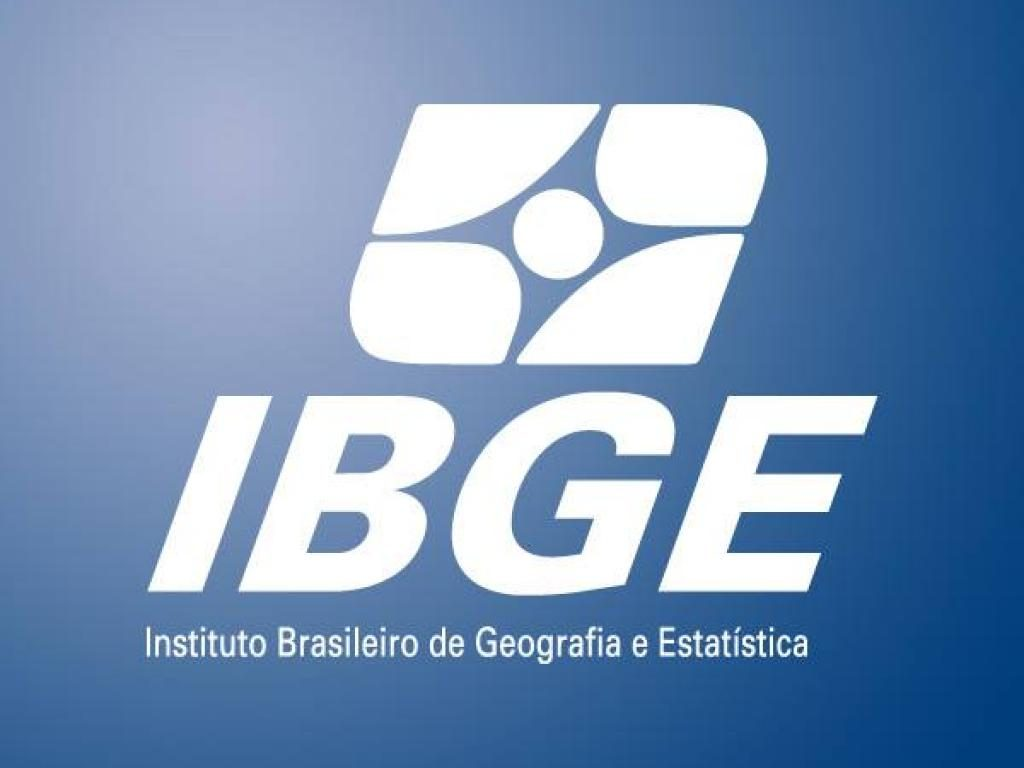

In [ ]:
desemprego19 = pd.read_csv('desemprego2019.csv', encoding = 'latin-1')

In [ ]:
desemprego20 = pd.read_csv('desemprego2020.csv', encoding = 'latin-1')

In [ ]:
# Join two Data Frames

porcentagem = pd.DataFrame({'Ano': ['2019', '2020'],
                           'Taxa de Ocupação': ['87.28%', '87.77%'],
                           'Taxa de Desocupação': ['12.72%', '12.72%']
                           })

In [ ]:
porcentagem.to_csv('porcentagem.csv', index = False)

In [ ]:
pd.read_csv('porcentagem.csv')

In [ ]:
empregados = pd.read_excel('Tabela 6466.xlsx', encoding = 'latin-1')

In [ ]:
# Data Cleaning empregados df

# Tabela mostra o nível da ocupação, na semana de referência, das pessoas de 14 anos ou mais de idade 
# Total, coeficiente de variação, variações em relação ao trimestre anterior e ao mesmo trimestre 
# do ano anterior, e média anual

# Drop rows that all values are missing
empregados.dropna(how='any', inplace=True) 

# Rename columns names
empregados.rename({
        'Tabela 6466 - Nível da ocupação, na semana de referência, das pessoas de 14 anos ou mais de idade - Total, coeficiente de variação, variações em relação ao trimestre anterior e ao mesmo trimestre do ano anterior, e média anual': 'Region', 
        'Unnamed: 1': '1º trimestre 2018', 'Unnamed: 2': '4º trimestre 2019 ', 
        'Unnamed: 3': '1º trimestre 2020' 
        }, axis='columns', inplace=True)

empregados.to_csv('empregados.csv', index = False)

In [ ]:
pd.read_csv('empregados.csv')

In [ ]:
desempregados = pd.read_excel('Tabela 6467.xlsx', encoding = 'latin-1')

In [ ]:
# Data Cleaning desempregados df

# Tabela que mostra o nível da desocupação, na semana de referência, das pessoas de 14 anos ou mais de idade
# Total, coeficiente de variação, variações em relação ao trimestre anterior e ao mesmo trimestre do ano 
# anterior, e média anual

# Drop rows that all values are missing
desempregados.dropna(how='any', inplace=True) 

# Rename columns names
desempregados.rename({
        'Tabela 6467 - Nível da desocupação, na semana de referência, das pessoas de 14 anos ou mais de idade - Total, coeficiente de variação, variações em relação ao trimestre anterior e ao mesmo trimestre do ano anterior, e média anual': 'Region', 
        'Unnamed: 1': '1º trimestre 2018', 'Unnamed: 2': '4º trimestre 2019 ', 
        'Unnamed: 3': '1º trimestre 2020' 
        }, axis='columns', inplace=True)

desempregados.to_csv('desempregados.csv', index = False)

In [ ]:
pd.read_csv('desempregados.csv')

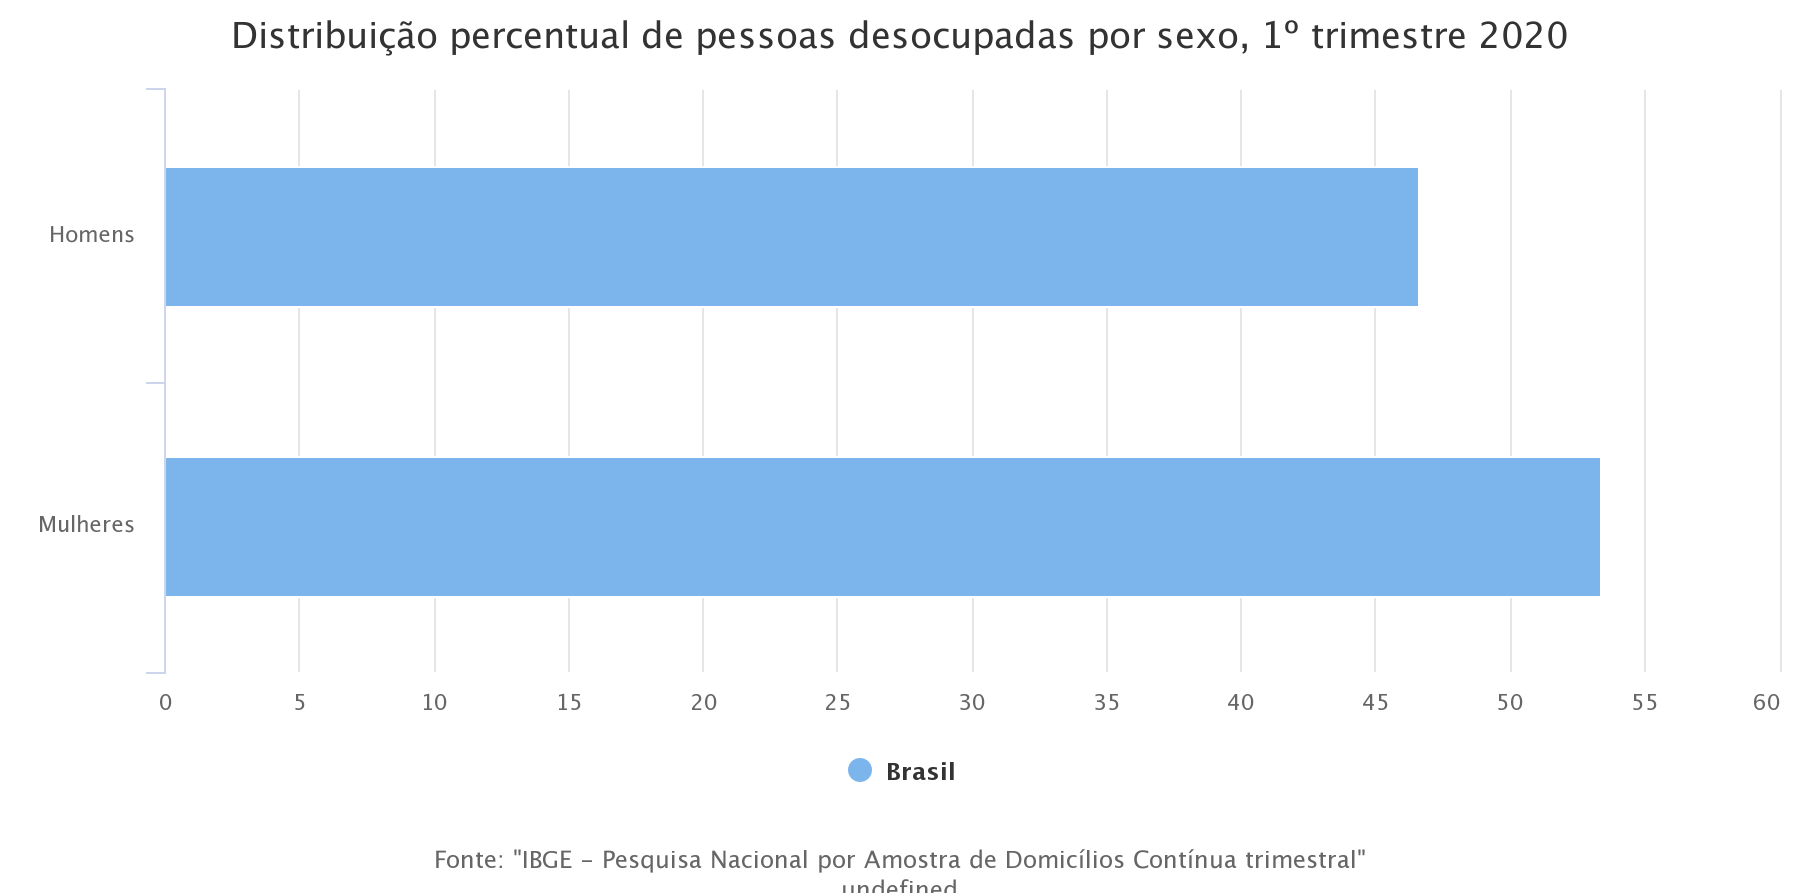

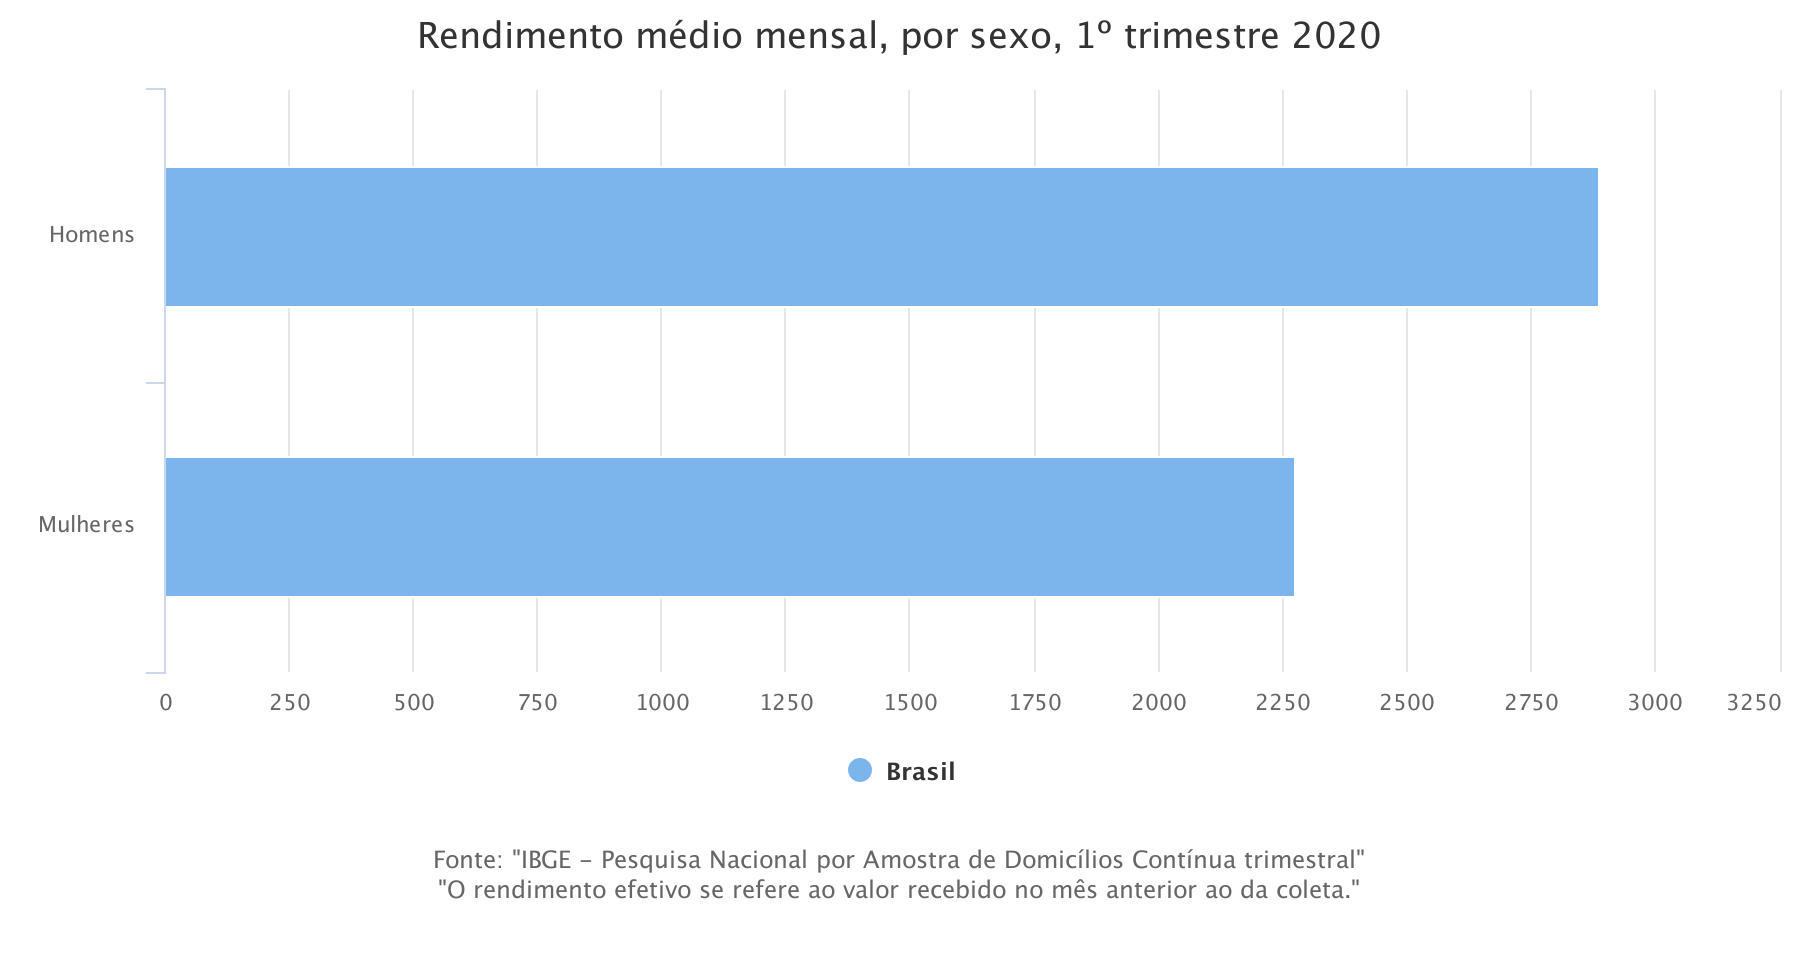